# Task: Goldfish-to-shark adversarial attack

You are given a set of images that are classified by a model trained on Imagenet as a goldfish (class `GOLDFISH_LABEL=1`).<br>
Your task is to compute a strip of pixels of height 10, which, when pasted into the top 10 rows of *each* of the original images, makes the model classify each image as a shark (class `SHARK_LABEL=2`) with returned probability at least 0.5.

This should run under 2 minutes on CPU.

## Data

Below you can find a piece of code that download a zipfile and displays the images.

In [1]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import zipfile
from io import BytesIO
from PIL import Image
from torch import Tensor
from torchvision.transforms import v2
from typing import cast

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


torch.use_deterministic_algorithms(True)


def get_images(
    url: str = "https://www.mimuw.edu.pl/~cygan/goldfish.zip",
    target_height: int = 100,
    target_width: int = 100,
) -> list[Tensor]:
    """Return five images as tensors of shape (C=3, H=target_height, W=target_width), 0..1 values."""
    request = requests.get(url)
    images = []
    with zipfile.ZipFile(BytesIO(request.content)) as z:
        for filename in z.namelist():
            if not filename.lower().endswith((".jpg", ".jpeg")):
                continue
            with z.open(filename) as f:
                images.append(Image.open(f).convert("RGB"))

    transformations = v2.Compose([
        v2.Resize(size=(target_height, target_width)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # scale to 0..1
    ])
    return [cast(Tensor, transformations(img)) for img in images]


def tensor_to_pil(image: Tensor) -> PIL.Image.Image:
    """Convert image tensor of shape (C, H, W), values 0..1, to PIL Image."""
    C, H, W = image.shape
    image = image.detach().permute(1, 2, 0).clone()  # to (H, W, C)
    img = PIL.Image.fromarray((image.numpy() * 255).astype(np.uint8))
    return img


normalize_colors = v2.Normalize(
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD
)

torch.Size([3, 100, 100])


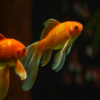

torch.Size([3, 100, 100])


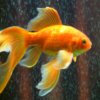

torch.Size([3, 100, 100])


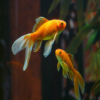

torch.Size([3, 100, 100])


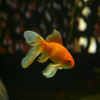

torch.Size([3, 100, 100])


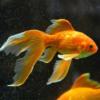

In [2]:
images = get_images()
for img in images:
    print(img.shape)
    display(tensor_to_pil(img))

## Model

We will be using the `mobilenet_v2` model, trained to do classification on the Imagenet dataset.
For this task, the model is a black-box: you do not have to know the details of the model's architecture.
In particular the model's weights should not be changed.

In [3]:
import torch.nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

DEFAULT_DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model(device: str = DEFAULT_DEVICE) -> torch.nn.Module:
    """Load a pretrained MobileNetV2 model.

    Input: normalized (not 0..1) images of shape (B, C, H, W),
    Output: logits (not probabilities or logprobs) of shape (B, num_classes=1000,).
    """
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.to(torch.device(device))
    model.eval()
    model.requires_grad_(False)
    return model

GOLDFISH_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("goldfish")
SHARK_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("great white shark")
GOLDFISH_LABEL, SHARK_LABEL

(1, 2)

In [4]:
model = get_model()
model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 101MB/s] 


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Evaluation

Below is a piece of code for:
* pasting the strip and running model inference on a normalized image;
* evaluating how well a strip performs, for this attack task.

In [5]:
STRIP_HEIGHT = 10

def evaluate_strip(model: torch.nn.Module, images: list[Tensor], strip: Tensor) -> None:
    """
    Print goldfish and shark probabilities for each image with the given strip pasted on top.

    Args:
    - model: the classification model.
    - images: list of tensors of shape (3, H, W), values 0..1
    - strip: tensor of shape (3, STRIP_HEIGHT, W), values 0..1.
    """
    C, H, W = images[0].shape
    assert strip.shape == (C, STRIP_HEIGHT, W)
    assert strip.min() >= 0 and strip.max() <= 1, f"Strip should be 0..1, got {strip.min()=}, {strip.max()=}."

    device = next(model.parameters()).device

    for img in images:
        img = img.clone().to(device)
        img[:, :strip.shape[1], :] = strip.to(device)
        img = normalize_colors(img)
        logits = model(img.unsqueeze(0)).squeeze(0)  # Shape (num_classes=1000,)
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        p_goldfish, p_shark = probabilities[[GOLDFISH_LABEL, SHARK_LABEL]]
        print(f'Probabilities assigned to: goldfish={p_goldfish:.5%}, shark={p_shark:.5%}.')


zero_strip = torch.zeros(3, STRIP_HEIGHT, images[0].shape[2])
evaluate_strip(model, images, zero_strip)

Probabilities assigned to: goldfish=99.91120%, shark=0.00000%.
Probabilities assigned to: goldfish=99.96259%, shark=0.00000%.
Probabilities assigned to: goldfish=95.45314%, shark=0.00000%.
Probabilities assigned to: goldfish=95.52149%, shark=0.00000%.
Probabilities assigned to: goldfish=99.78421%, shark=0.00000%.


## TO IMPLEMENT

Here you have to implement the function that finds the strip.


In [6]:
def calculate_strip(model: torch.nn.Module, images: list[Tensor], seed: int = 1, quiet: bool = False) -> Tensor:
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    model.eval()

    whole_rand_input = torch.randn(1, 3, 100, 100)
    whole_rand_input.requires_grad = False
    strip = torch.randn(1, 3, 10, 100, requires_grad=True)

    optimizer = torch.optim.Adam([strip], lr = 0.1)


    for step in range(300):
        optimizer.zero_grad()

        loss = 0.0
        for img in images:
            img = img.clone()

            img[:, :10, :] = strip.clamp(0, 1)
            img = normalize_colors(img)

            logits = model(img.unsqueeze(0)).squeeze(0)
            probs = torch.nn.functional.softmax(logits, dim=-1)

            loss -= torch.log(probs[SHARK_LABEL])

        loss = loss / len(images)

        loss.backward()
        optimizer.step()

        strip.data.clamp_(0, 1)

        if step % 20 == 0:
            print(f"Step {step}: loss = {loss.item():.4f}")


    return strip


your_strip = calculate_strip(model, images)

Step 0: loss = 22.2283
Step 20: loss = 9.6211
Step 40: loss = 3.8262
Step 60: loss = 1.5277
Step 80: loss = 0.6125
Step 100: loss = 0.2095
Step 120: loss = 0.1109
Step 140: loss = 0.0802
Step 160: loss = 0.0659
Step 180: loss = 0.0574
Step 200: loss = 0.0509
Step 220: loss = 0.0456
Step 240: loss = 0.0405
Step 260: loss = 0.0354
Step 280: loss = 0.0306


In [7]:
display(tensor_to_pil(your_strip[0]))

In [8]:
evaluate_strip(model, images, your_strip[0])

Probabilities assigned to: goldfish=0.02245%, shark=97.43125%.
Probabilities assigned to: goldfish=0.71256%, shark=95.86706%.
Probabilities assigned to: goldfish=0.00272%, shark=98.70076%.
Probabilities assigned to: goldfish=0.00193%, shark=97.02885%.
Probabilities assigned to: goldfish=0.16421%, shark=97.63218%.


torch.Size([3, 100, 100])


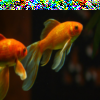

torch.Size([3, 100, 100])


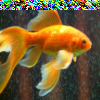

torch.Size([3, 100, 100])


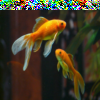

torch.Size([3, 100, 100])


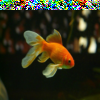

torch.Size([3, 100, 100])


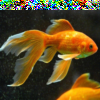

In [9]:
o_kurwa_rekin = []
for img in images:
    img = img.clone()
    img[:, :10, :] = your_strip
    o_kurwa_rekin.append(img)
    print(img.shape)
    display(tensor_to_pil(img))